# CSCA-5642: Final Project #
#### Develop an temporal sequence classifier to recognize action from video clips. ####
    
* Author: Alexander Meau  
* Email: alme9155@colorado.edu  
* GitHub: [https://github.com/alme9155/csca-5642-week4/tree/main](https://github.com/alme9155/csca-5642-week4/tree/main)  

<imag src="https://storage.googleapis.com/kaggle-datasets-images/2232355/3733921/1aa7cf2963836e7be0a22c2888d60b87/dataset-cover.jpg?t=2022-06-02-06-19-02" alt="." width="300">

## I. Brief description of the problem and data ##

This project explores the application of deep neural networks for human action recognition (HAR) in video sequences. Human action recognition has a wide range of practical applications, including sports analytics, robotics, and surveillance systems. By leveraging architectures such as CNN+LSTM and 3D Convolutional Networks (C3D), this study aims to compare the effectiveness of different algorithmic designs. Key challenges include modeling long-term temporal dependencies and handling variations in video length, lighting conditions, and resolution.

### Dataset: ####
* The UCF50 dataset is a collection of video clips, such as Baseball pitch, kayaking, diving, etc created by the University of Central Florida, Center for Research in Computer Vision. 
* The UCF50 dataset is a reduced dataset from the original 101 action categories database.
* Ref: [https://www.crcv.ucf.edu/data/UCF101.php](https://www.crcv.ucf.edu/data/UCF101.php).
  
### Data Size and Dimension ####
* Dataset: Total 6999 avi files acrsso 50 categories.
* Each category has an average of 100-170 .avi video files (average ~133 per category).
* Most of the video clips are in the same resolutions (width=320 x height=240 x channel=3)
* Video lengths varies in temporal resolution (frames per second).
* Videos includes various viewpoints, scales, camera motion, and lighting conditions, making it a challenging dataset for action recognition tasks. 

In [62]:
import os
import pandas as pd
import matplotlib.pyplot as plt

category_counts = {}
input_path = '/kaggle/input/ucf50-latest-version/UCF50/'
for dirname, _, filenames in os.walk(input_path):
    avi_file_count = sum(1 for f in filenames if f.endswith('.avi'))
    
    if avi_file_count > 0:
        category_name = os.path.basename(dirname)
        category_counts[category_name] = avi_file_count

df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', '# AVI Files'])
df_counts = df_counts.sort_values(by='# AVI Files', ascending=False).reset_index(drop=True)
display(df_counts)
print(f"\nTotal .avi file count = {df_counts['# AVI Files'].sum()}")
print(f"Average .avi file count = {df_counts['# AVI Files'].mean()}")


Category  # AVI Files
0          HorseRiding          197
1          TennisSwing          167
2             Drumming          161
3                Punch          160
4            PoleVault          160
5           BenchPress          160
6        PlayingGuitar          160
7             Kayaking          157
8       SoccerJuggling          156
9               Diving          153
10           Nunchucks          150
11           Billiards          150
12  RockClimbingIndoor          148
13            JumpRope          148
14              Biking          145
15              Skiing          144
16           GolfSwing          142
17              Lunges          141
18              Mixing          141
19       BaseballPitch          138
20          Basketball          137
21               Swing          137
22              Rowing          137
23           SalsaSpin          133
24         ThrowDiscus          131
25        RopeClimbing          130
26                YoYo          128
27           HorseRace          127
28      MilitaryParade          127
29            HulaHoop          125
30        PlayingTabla          124
31            HighJump          123
32         JumpingJack          123
33      WalkingWithDog          123
34         PommelHorse          123
35       JugglingBalls          122
36       SkateBoarding          120
37             PullUps          120
38   TrampolineJumping          119
39        JavelinThrow          117
40   VolleyballSpiking          116
41        PizzaTossing          114
42        CleanAndJerk          112
43             Fencing          111
44             PushUps          106
45        PlayingPiano          105
46        BreastStroke          101
47              Skijet          100
48       PlayingViolin          100
49              TaiChi          100


Total .avi file count = 6669
Average .avi file count = 133.38


## II. Exploratory Data Analysis (EDA) ##
- Examine video quality:
  - Dimension (width x height)
  - Frame Count and Frame per secound
  - Total count of video clips
  - Total count of video category

In [36]:
import os
import cv2
import pandas as pd
from collections import defaultdict


dataset_root = '/kaggle/input/ucf50-latest-version/UCF50/'
video_profile_stats = defaultdict(lambda: {'Video Count': 0, 'Category Count': set()})
for root, _, files in os.walk(dataset_root):
    for file in files:
        if file.endswith('.avi'):
            video_path = os.path.join(root, file)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                continue

            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration = round(frame_count / fps, 1) if fps > 0 else 0
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            resolution = f"{width}x{height}"
            category = os.path.basename(os.path.dirname(video_path))
            #key = (resolution, round(fps, 2), frame_count, duration)
            ret, frame = cap.read()
            channel =1
            if ret and frame is not None and len(frame.shape) == 3:
                channel = frame.shape[2]
            key = (resolution, round(fps, 2), frame_count, duration, channel)
            
            # Accumulate count
            video_profile_stats[key]['Video Count'] += 1
            video_profile_stats[key]['Category Count'].add(category)
            cap.release()

# Convert to DataFrame
summary_rows = []
for key, stats in video_profile_stats.items():
    resolution, fps, frame_count, duration, channel = key
    video_count = stats['Video Count']
    category_count = len(stats['Category Count'])
    summary_rows.append({
        'Resolution': resolution,
        'Frame per sec': fps,
        'Frame Count': frame_count,
        'Duration in sec': duration,
        'Channels': channels,
        'Video Count': video_count,
        'Category Count': category_count
    })

print("\nAccumulated Video Stats Summary:\n")
df_summary = pd.DataFrame(summary_rows).sort_values(by='Video Count', ascending=False).reset_index(drop=True)
display(df_summary)




Accumulated Video Stats Summary:



Resolution  Frame per sec  Frame Count  Duration in sec  Channels  \
0      320x240          25.00          300             12.0         3   
1      320x240          29.97          240              8.0         3   
2      320x240          25.00          250             10.0         3   
3      320x240          29.97          201              6.7         3   
4      320x240          25.00          168              6.7         3   
..         ...            ...          ...              ...       ...   
827    320x240          29.97          641             21.4         3   
828    320x240          29.97          147              4.9         3   
829    320x240          25.00           58              2.3         3   
830    320x240          29.97          621             20.7         3   
831    320x240          29.97          377             12.6         3   

     Video Count  Category Count  
0            275               9  
1            256               7  
2            171               8  
3            101              10  
4             64              15  
..           ...             ...  
827            1               1  
828            1               1  
829            1               1  
830            1               1  
831            1               1  

[832 rows x 7 columns]

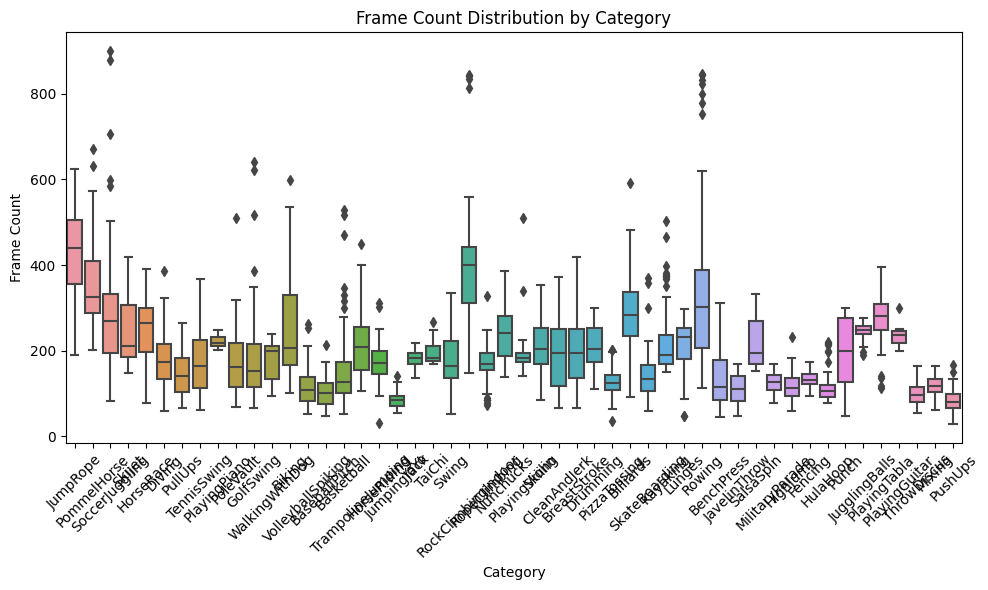

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

category_stats = []
for key, stats in video_profile_stats.items():
    resolution, fps, frame_count, duration, channel = key
    input_shape = f"{frame_count}x{height}x{width}x3"  
    for category in stats['Category Count']:
        category_stats.append({
            'Category': category,
            'Resolution': resolution,
            'Frame per sec': fps,
            'Frame Count': frame_count,
            'Duration in sec': duration,
            'Channels': channels,
            'Input Shape': input_shape,
            'Video Count': stats['Video Count'],  # shared across all category entries here
        })

df_category_stats = pd.DataFrame(category_stats)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_category_stats, x='Category', y='Frame Count')
plt.xticks(rotation=45)
plt.title("Frame Count Distribution by Category")
plt.tight_layout()
plt.show()

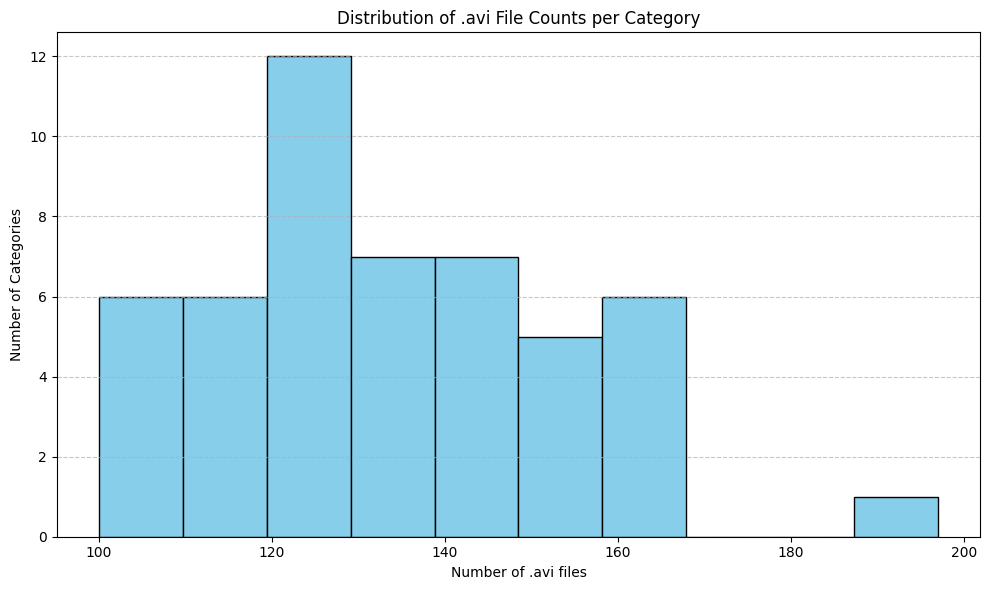

In [61]:
plt.figure(figsize=(10, 6))
plt.hist(df_counts['# AVI Files'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of .avi File Counts per Category')
plt.xlabel('Number of .avi files')
plt.ylabel('Number of Categories')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## III. EDA Summary and Analysis ##

### Summary ###
* The dataset contains ~7,000 .avi video files (exactly 6,669) across 50 action categories.
  * Most categories contain between 110 and 150 video clips.
  * There is no extreme class imbalance in terms of video count per category.
* Almost all of the videos has same spatial size and color format.
  * Width x Height x Channel = 320 x 240 x 3
* There are large variation in frame count.
  * Frame count ranges from 58 to 641.
  * Some categories has total frames > 500-800. (e.g. Jump Rope, Horse Race)
  * Other categories stay under < 150 frames (e.g. Push Ups)
  * Many action categories contain significant outliers in frame count.

### Analysis ###
* Due to the volume of dataset, and the limited GPU quotas on Kaggle platform, **10 video categories** have been selected to reduce the input dataset.
 * 10 selected video categories:
    * **'HighJump', 'Basketball', 'TennisSwing', 'CleanAndJerk', 'PushUps'**
    * **'JumpingJack', 'SkateBoarding', 'TrampolineJumping', 'Lunges', 'GolfSwing'**
 * Reducing the input dataset can help reduce training time.

* Even though the input dataset is reduced to less number .avi files to process, data preparation is still required to standardize video input shape before applying deep learning model.
  *  Deep learning model expect fixed input shapes in the form: (Frames × Height × Width × Channels)
  *  The OpenCV library returns images in BGR, but most pre-trained models expect RGB format.
  *  Although the clips are in consistent dimensions (320×240×3), it is best to resize to 112×112×3:
      *  Reducing the spatial dimensions helps lower memory usage and improves processing speed.
      *  Pre-trained models such as R(2+1)D and C3D are designed to operate on 112×112 inputs.
  * Ref: [https://openaccess.thecvf.com/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf](https://openaccess.thecvf.com/content_iccv_2015/papers/Tran_Learning_Spatiotemporal_Features_ICCV_2015_paper.pdf)

In [54]:
# Common constants
base_path = '/kaggle/input/ucf50-latest-version/UCF50/'
selected_categories = [
    'HighJump', 'Basketball', 'TennisSwing', 'PullUps', 'PushUps',
    'JumpingJack', 'SkateBoarding', 'TrampolineJumping', 'Lunges', 'GolfSwing'
]

In [ ]:
### III.i Data Pre-processing ###


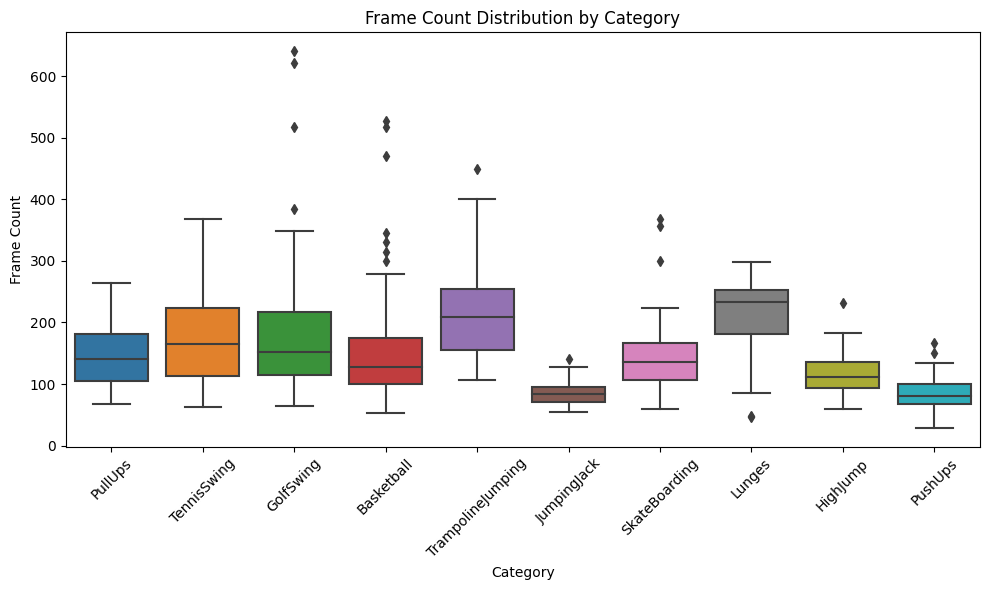

In [58]:
selected_categories = [
    'HighJump', 'Basketball', 'TennisSwing', 'PullUps', 'PushUps',
    'JumpingJack', 'SkateBoarding', 'TrampolineJumping', 'Lunges', 'GolfSwing'
]


df_reduced_category_stats = df_category_stats[df_category_stats['Category'].isin(selected_categories)]
df_reduced_category_stats.head()
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_reduced_category_stats, x='Category', y='Frame Count')
plt.xticks(rotation=45)
plt.title("Frame Count Distribution by Category")
plt.tight_layout()
plt.show()


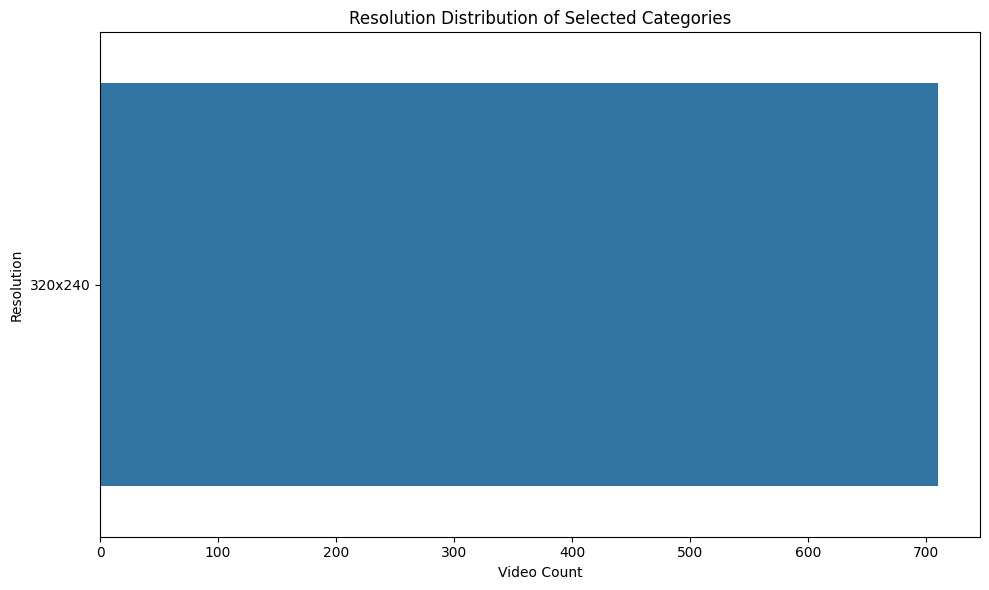

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_categories = [
    'HighJump', 'Basketball', 'TennisSwing', 'PullUps', 'PushUps',
    'JumpingJack', 'SkateBoarding', 'TrampolineJumping', 'Lunges', 'GolfSwing'
]

# Filter to selected categories
df_selected = df_category_stats[df_category_stats['Category'].isin(selected_categories)]

# Count plot of resolutions
plt.figure(figsize=(10, 6))
sns.countplot(data=df_selected, y='Resolution', order=df_selected['Resolution'].value_counts().index)
plt.title("Resolution Distribution of Selected Categories")
plt.xlabel("Video Count")
plt.ylabel("Resolution")
plt.tight_layout()
plt.show()


Category: HighJump


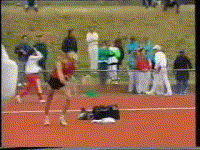

Category: Basketball


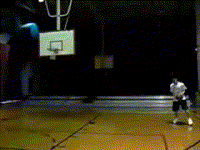

Category: TennisSwing


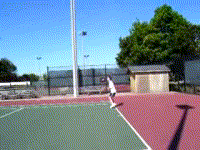

Category: PullUps


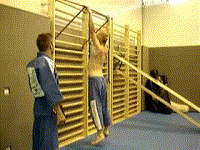

Category: PushUps


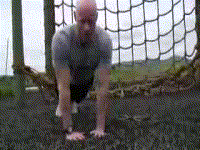

Category: JumpingJack


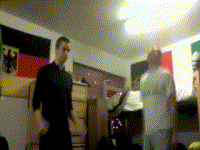

Category: SkateBoarding


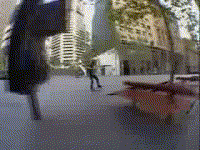

Category: TrampolineJumping


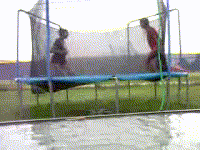

Category: Lunges


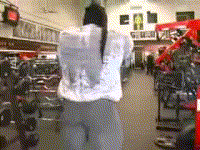

Category: GolfSwing


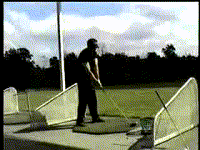

In [56]:
import os
import warnings
import tempfile
from IPython.display import Image, display
from moviepy.editor import VideoFileClip

warnings.filterwarnings('ignore')
if 'XDG_RUNTIME_DIR' not in os.environ:
    os.environ['XDG_RUNTIME_DIR'] = '/tmp/runtime-dir'
    os.makedirs(os.environ['XDG_RUNTIME_DIR'], exist_ok=True)

def video_to_gif(video_path):
    try:
        with tempfile.NamedTemporaryFile(suffix='.gif', delete=False) as tmp_file:
            gif_filename = tmp_file.name        
        clip = VideoFileClip(video_path, audio=False).subclip(0, min(5, VideoFileClip(video_path, audio=False).duration))
        #clip = clip.resize(width=320)  
        clip = clip.resize(width=200) 
        clip.write_gif(gif_filename, fps=10, program='ffmpeg', logger=None)  
        clip.close() 
        return gif_filename
    except Exception as e:
        return None

for category in selected_categories:
    category_path = os.path.join(base_path, category)
    avi_files = [f for f in os.listdir(category_path) if f.endswith('.avi')]
    if avi_files:
        sample_video = os.path.join(category_path, avi_files[0])  
        print(f"Category: {category}")
        #print(f"Sample Video: {sample_video}")
        gif_filename = video_to_gif(sample_video)
        if gif_filename and os.path.exists(gif_filename):
            display(Image(filename=gif_filename))
            os.remove(gif_filename) 


### II.ii. Pre-process the data ###

- Preprocess and split the data 80/20 into training and validation dataset
- Prepare load_image method to be used
- Prepare tensor pipeline to load image, label pair in mini-batch of 64

## IV. Model Architecture ##

### Model Description ###

- This model implements traditional CNN model with three layers architecture.
- Model begins with 32 filters, and then this hyperparameter value doubled of each subsequent layer: 32, 64, 128 
- Since each image size is 96 x 96 pixel of RGB channel, input shape = (96,96, 3)
- To avoid overfitting, each convolution block is matched with pooling layer and batch-normalization.
- First layer use 5x5 kernel to learn major feature and then 3x3 kernel following inspiration of VGG-16. 

#### Reference ###
- Ref: https://www.geeksforgeeks.org/computer-vision/vgg-16-cnn-model
- Ref: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf

<img src="https://developers.google.com/static/machine-learning/practica/image-classification/images/cnn_architecture.svg" width="600">

In [ ]:
print('III')

## V. Result Analysis Before Fine-Tuning ##

- Overall, this CNN model performs moderately for the histopathologic cancer detection task before tuning, as it has a simple architecture and achieves 87% accuracy on the validation dataset. 

### Details ###
- At the end, this simplistic CNN model achieves 94% accuracy in the training dataset, but drops accuracy to 87% in the validation set. The drop in accuracy suggested that the model might have overfit the training dataset.
- The curve of training loss starts at 0.4 and decreases steadily to 0.1 around epoch 8. However, validation loss spikes sharply, and this suggest the model is memorizing the training data rather than generalizing it.
- The accuracy curve follows similiar patterns as in the curve of the training loss. Even though there are spikes with the validation curve, the validation accuracy improved gradually.
- Spikes are also observed in the AUC curve, but it did achieve the highest value of 0.97, suggesting the model is highly effective despite fluctuations.


## VI. Explore Different CNN Model Architectures ##

My approach to explore different Convolutional Neural Network (CNN) architectures is as follows:

- Compare CNN model performance of same layout with higher and lower convolution layers
  - **2 convolutional layers**
  - **3 convolutional layers**
  - **5 convolutional layers**


In [ ]:
print('V')

## VII. Performance Analysis with Different Model Architectures ##

- Deeper model achieve higher traing and validation accuracy
  - 5 layer CNN reach 97% training accuracy, compared to 94% (3 layers), and 84% (2 layers)
  - 5 layer CNN reach 93% training accuracy, compared to 88% (3 layers), and 86% (2 layers)
  - Deeper network have greater capacity to learn more complex pattern

- Deeper model may introduce higher risk of overfitting
  - 5 layer model have relatively deeper gap between training and validation accuracy.
  - Performance gap widens with depth, suggesting a higher risk of overfitting and early stopping is required (next performance tuning).

In [ ]:
print('VI')

## VIII. Hyper-parameter Fine-Tuning by reducing Number of Filters ##

* **Validation accuracy lower than training accuracy** indicates **overfitting**, where the model performs well on training data but fails to generalize to unseen data.
* Overfitting may result from too many filters that learn noise patterns from the training data.
* Less number of filters encouraging to focus on essential patterns rather than memorizing training data.

- Three set number of filters be used for performance comparison:
  - (16, 32, 64, 128, 256), 
  - (24, 48, 96, 192, 384)
  - (32, 64, 128, 256, 512) (best model architecture)


## XII. Conclusion ##

### Best performance is achieved with the following configurations ###
- Model Architecture: 5 convoluntion block + output block
- Input shape: (96, 96, 3)
- Kernel size=5 for the 1st convolution block, and kernel size=3 for the rest.
- Stride=1, padding=same,
- Each convolution block include batchnormation max pooling size=2, strides=2
- Filter configuration: 32, 64, 128, 256, 512
- Learning rate: default (0.001) with Early stopping


Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

### Results ###
- High precision and specificity mean the model is reliable with high numbers of TP and TN
- Moderate false negative rate (1,881 missed cases) 


| Metric               | Formula                          | Value     |
|----------------------|----------------------------------|-----------|
| Accuracy             | (TP + TN) / (TP + TN + FP + FN) | 0.9348    |
| Precision (PPV)      | TP / (TP + FP)                  | 0.9489    |
| Recall (Sensitivity) | TP / (TP + FN)                  | 0.8946    |
| Specificity          | TN / (TN + FP)                  | 0.9672    |
| F1 Score             | 2 * (Precision * Recall) / (Precision + Recall) | 0.9209    |

Confusion Matrix:
|                  | Predicted Negative | Predicted Positive | Total   |
|------------------|--------------------|---------------------|---------|
| **Actual Negative** | TN = 25,322 (58.9%) | FP = 860 (2.0%)       | 26,182 (60.9%) |
| **Actual Positive** | FN = 1,881 (4.4%)   | TP = 15,942 (37.1%)    | 17,823 (39.1%) |
| **Total**          | 27,203 (63.2%)     | 16,802 (36.8%)         | 43,005 (100%) |


### What improve the performance of the model ###
- Deeper model achieve higher traing and validation accuracy
  - 5 layer CNN reach 97% training accuracy, compared to 94% (3 layers), and 84% (2 layers)
  - 5 layer CNN reach 93% training accuracy, compared to 88% (3 layers), and 86% (2 layers)
  - Deeper network have greater capacity to learn more complex pattern

- Deeper model may introduce higher risk of overfitting
  - 5 layer model have relatively deeper gap between training and validation accuracy.
  - Performance gap widens with depth, suggesting a higher risk of overfitting and early stopping is required.

- Increase filter depth helped feature extraction:
  - The spike in the validation history suggests that the model has learned enough useful features to achieve a high AUC score, but still requires further regularization.
  - Even though fewer filter configurations (24, 48, 96, 192, 384) might have improved regularization, they do not learn enough complex features to exceed the original (32, 64, 128, 256, 512) filter configuration.  -     - Filter configuration (16, 32, 64, 128, 256) performs the worst because it lacks the capacity to capture complex patterns.
  - Thus, for the best model submission, **filter configurations (32, 64, 128, 256, 512) remains the best choice.**

- Early stopping protects against overfitting but requires appropriate learning rates for optimal effect.
  - Learning rate =0.001 (default) achieve the highest accuracy (0.93) and AUC (0.97)
  - When the learning rate is reduced (rate = 0.0005), slower convergence might have caused the model to underfit before early stopping, halting the training.
  - When the learning rate is increased (rate=0.005), faster convergence may cause instability without reaching the optimum.

### What improvement could you try in the future? ###
- More complex convolution model such as VGG-16/ VGG-32 by Oxford University [https://www.robots.ox.ac.uk/~vgg/research/very_deep/](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
- Explore vision transformer(ViT) developed by Google Deep Brain Team [https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/](https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/)

## XIII. Future Works and References ##
- Experiment with VGG-16, VGG-32 by Oxford University [https://www.robots.ox.ac.uk/~vgg/research/very_deep/](https://www.robots.ox.ac.uk/~vgg/research/very_deep/)
- Explore with Visual Transformer by Google Deep Brain [https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/](https://deepmind.google/discover/blog/rt-2-new-model-translates-vision-and-language-into-action/)

### References ###
- Ref: Tensor flow tutorial [https://www.tensorflow.org/tutorials](https://www.tensorflow.org/tutorials) 
- Ref: TensorFlow Guide: [https://www.tensorflow.org/guide/keras/](https://www.tensorflow.org/guide/keras/)